In [1]:
!pip install -q darts

     |████████████████████████████████| 290 kB 5.3 MB/s 
     |████████████████████████████████| 791 kB 33.3 MB/s 
     |████████████████████████████████| 155 kB 33.8 MB/s 
     |████████████████████████████████| 1.4 MB 17.9 MB/s 
     |████████████████████████████████| 65 kB 3.3 MB/s 
     |████████████████████████████████| 9.8 MB 33.6 MB/s 
     |████████████████████████████████| 11.2 MB 49.4 MB/s 
     |████████████████████████████████| 177 kB 50.8 MB/s 
     |████████████████████████████████| 374 kB 46.8 MB/s 
     |████████████████████████████████| 884 kB 51.5 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 216 kB 51.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.24 which is incompatible.
google-colab 1

In [2]:
!pip install -q matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 110 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
darts 0.14.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
import sklearn.preprocessing as preprocessing

In [4]:
df = pd.read_csv('Electricity_demand.csv')

In [5]:
df.head(5)

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


In [6]:
df.shape

(2106, 14)

In [7]:
df.columns

Index(['date', 'demand', 'RRP', 'demand_pos_RRP', 'RRP_positive',
       'demand_neg_RRP', 'RRP_negative', 'frac_at_neg_RRP', 'min_temperature',
       'max_temperature', 'solar_exposure', 'rainfall', 'school_day',
       'holiday'],
      dtype='object')

In [8]:
df.dtypes

date                object
demand             float64
RRP                float64
demand_pos_RRP     float64
RRP_positive       float64
demand_neg_RRP     float64
RRP_negative       float64
frac_at_neg_RRP    float64
min_temperature    float64
max_temperature    float64
solar_exposure     float64
rainfall           float64
school_day          object
holiday             object
dtype: object

In [9]:
le = preprocessing.LabelEncoder()
df['school_day'] = le.fit_transform(df.school_day.values)
df['holiday'] = le.fit_transform(df.holiday.values)

In [10]:
df['date'] = df['date'].apply(pd.to_datetime)

In [11]:
torch.manual_seed(1); np.random.seed(1)  # for reproducibility

In [12]:
df.isna().sum()

date               0
demand             0
RRP                0
demand_pos_RRP     0
RRP_positive       0
demand_neg_RRP     0
RRP_negative       0
frac_at_neg_RRP    0
min_temperature    0
max_temperature    0
solar_exposure     1
rainfall           3
school_day         0
holiday            0
dtype: int64

In [13]:
df = df.fillna(0)

In [14]:
df.head(5)

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,0,1
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,0,0
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,0,0
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,0,0
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,0,0


In [31]:
df.tail()

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
2101,2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,0,0
2102,2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,0,0
2103,2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.570,-0.163066,0.062500,13.5,29.5,8.4,0.0,0,0
2104,2020-10-05,113610.030,36.764701,106587.375,39.616015,7022.655,-6.511550,0.083333,9.1,12.7,7.3,12.8,0,0
2105,2020-10-06,122607.560,75.771059,122607.560,75.771059,0.000,0.000000,0.000000,8.9,12.6,5.8,1.0,0,0


In [15]:
series = TimeSeries.from_dataframe(df, 'date', 'demand',fill_missing_dates=True)

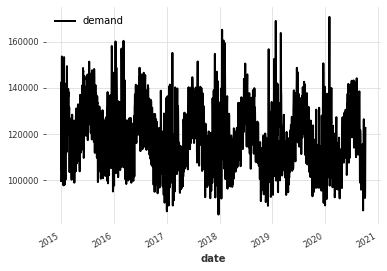

In [16]:
series.plot()
plt.show()

In [43]:
train, val = series.split_after(pd.Timestamp('20200910'))
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
val_transformed = scaler.transform(val)
series_transformed = scaler.transform(series)

In [44]:
covariates = TimeSeries.from_dataframe(df,'date',['min_temperature' ,'max_temperature' ,'solar_exposure','rainfall' ,'school_day','holiday'],fill_missing_dates=True)

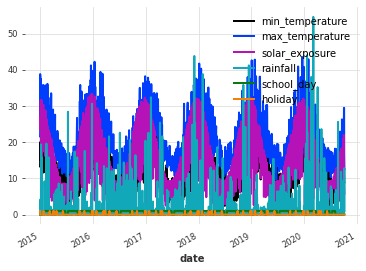

In [45]:
covariates.plot()

In [46]:
len(covariates)

2106

In [47]:
# create month and year covariate series
year_series = datetime_attribute_timeseries(pd.date_range(start=series.start_time(), freq=series.freq_str, periods=2106),
                                             attribute='year', one_hot=False)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)
time_covariates = year_series.stack(month_series)

In [48]:
cov = time_covariates.stack(covariates)

In [49]:
scaler = Scaler()
train_cov, val_cov = cov.split_after(pd.Timestamp('20200910'))
train_cov_transformed = scaler.fit_transform(train_cov)
val_cov_transformed = scaler.transform(val_cov)
covariates_transformed = scaler.transform(cov)

In [50]:
model_cov = BlockRNNModel(
    model='LSTM',
    input_chunk_length=30,
    output_chunk_length=20,
    n_epochs=300,
    random_state=0
)

In [51]:
model_cov.fit(series=train_transformed,
              past_covariates=train_cov_transformed,
              verbose=True)

[2021-12-10 12:14:16,978] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2031 samples.
[2021-12-10 12:14:16,978] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2031 samples.
[2021-12-10 12:14:16,988] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-10 12:14:16,988] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  0%|          | 1/300 [00:01<06:18,  1.27s/it]

  4%|▎         | 11/300 [00:13<06:04,  1.26s/it]

  7%|▋         | 21/300 [00:26<05:48,  1.25s/it]

 10%|█         | 31/300 [00:38<05:34,  1.24s/it]

 14%|█▎        | 41/300 [00:51<05:21,  1.24s/it]

 17%|█▋        | 51/300 [01:03<05:09,  1.24s/it]

 20%|██        | 61/300 [01:16<04:56,  1.24s/it]

 24%|██▎       | 71/300 [01:28<04:42,  1.23s/it]

 27%|██▋       | 81/300 [01:41<04:32,  1.24s/it]

 30%|███       | 91/300 [01:53<04:18,  1.24s/it]

 34%|███▎      | 101/300 [02:05<04:05,  1.23s/it]

 37%|███▋      | 111/300 [02:18<03:56,  1.25s/it]

 40%|████      | 121/300 [02:30<03:42,  1.25s/it]

 44%|████▎     | 131/300 [02:43<03:28,  1.23s/it]

 47%|████▋     | 141/300 [02:55<03:19,  1.26s/it]

 50%|█████     | 151/300 [03:08<03:06,  1.25s/it]

 54%|█████▎    | 161/300 [03:20<02:52,  1.24s/it]

 57%|█████▋    | 171/300 [03:33<02:40,  1.25s/it]

 60%|██████    | 181/300 [03:45<02:28,  1.25s/it]

 64%|██████▎   | 191/300 [03:58<02:16,  1.25s/it]

 67%|██████▋   | 201/300 [04:10<02:02,  1.23s/it]

 70%|███████   | 211/300 [04:22<01:49,  1.23s/it]

 74%|███████▎  | 221/300 [04:35<01:36,  1.22s/it]

 77%|███████▋  | 231/300 [04:47<01:25,  1.24s/it]

 80%|████████  | 241/300 [04:59<01:13,  1.25s/it]

 84%|████████▎ | 251/300 [05:12<01:00,  1.23s/it]

 87%|████████▋ | 261/300 [05:24<00:48,  1.24s/it]

 90%|█████████ | 271/300 [05:36<00:35,  1.23s/it]

 94%|█████████▎| 281/300 [05:49<00:23,  1.26s/it]

 97%|█████████▋| 291/300 [06:01<00:11,  1.24s/it]

100%|██████████| 300/300 [06:12<00:00,  1.24s/it]


In [53]:
predicted = model_cov.predict(n=20)

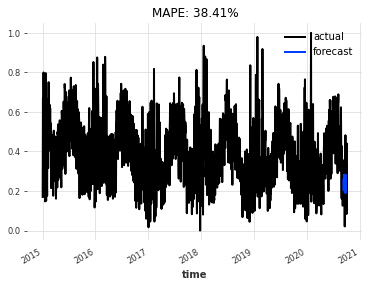

In [54]:
series_transformed.plot(label='actual')
predicted.plot(label='forecast')
plt.title('MAPE: {:.2f}%'.format(mape(predicted, val_transformed[:20])))
plt.legend()
plt.show()